[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vietanhdev/sdc-tutorial/blob/master/notebooks/Traffic-Sign-Detection.ipynb)

# Build your own self-driving car on simulation - Part 2: Traffic sign detection

Develop your own self-driving algorithms, from lane line detection, traffic sign, and car control.

**Authors:** [vietanhdev](https://github.com/vietanhdev), [ducnguyenhuynh](https://github.com/ducnguyenhuynh).

In addition to staying on the right side of the road and lane, self-driving cars must also obey traffic signals such as traffic signs and traffic lights. In this section, we will apply image processing techniques and AI to detect and classify traffic signs on the road.

The basic sign detection and classification flow will consist of 3 main steps:

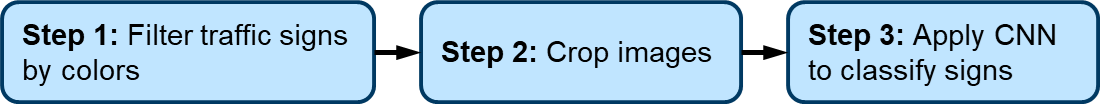

In the first step, the image will be put into a color filter to select all areas that are blue or red, possibly a traffic sign. Then, these regions are cut apart into small image regions in step 2 and put into a convolutional neural network in step 3 to perform classification to determine the type of traffic signs or unknown objects.



In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## 1. Filter signs by color

HSV color space has a good ability to distinguish colors. In order to detect sign objects by color, we convert images into HSV color system and use thresholds to filter colors.

First, we will download and use a few sample images to test the algorithm. The images we will be testing on are contributed by members of [ICT team K60, Hanoi University of Science and Technology](https://aicurious.io/posts/chung-toi-da-xay-dung-xe-tu-hanh-tren-gia-lap-the-nao/).

In [2]:
!wget https://github.com/vietanhdev/sdc-tutorial/raw/master/content/images/traffic_sign_images.zip
!unzip -qo traffic_sign_images.zip

--2021-12-04 11:04:54--  https://github.com/vietanhdev/sdc-tutorial/raw/master/content/images/traffic_sign_images.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vietanhdev/sdc-tutorial/master/content/images/traffic_sign_images.zip [following]
--2021-12-04 11:04:54--  https://raw.githubusercontent.com/vietanhdev/sdc-tutorial/master/content/images/traffic_sign_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129341 (126K) [application/zip]
Saving to: ‘traffic_sign_images.zip’

traffic_sign_images 100%[===================>] 126.31K  --.-KB/s    in 0.02s   

2021-12-04 11:04:55 (5.74 

### Show images

In [3]:
def show_images(images, cmap="viridis"):
    column = 3
    row = int(math.ceil(len(images)/column))
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(row,column,i+1)
        if cmap != "gray":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

range(1, 7)


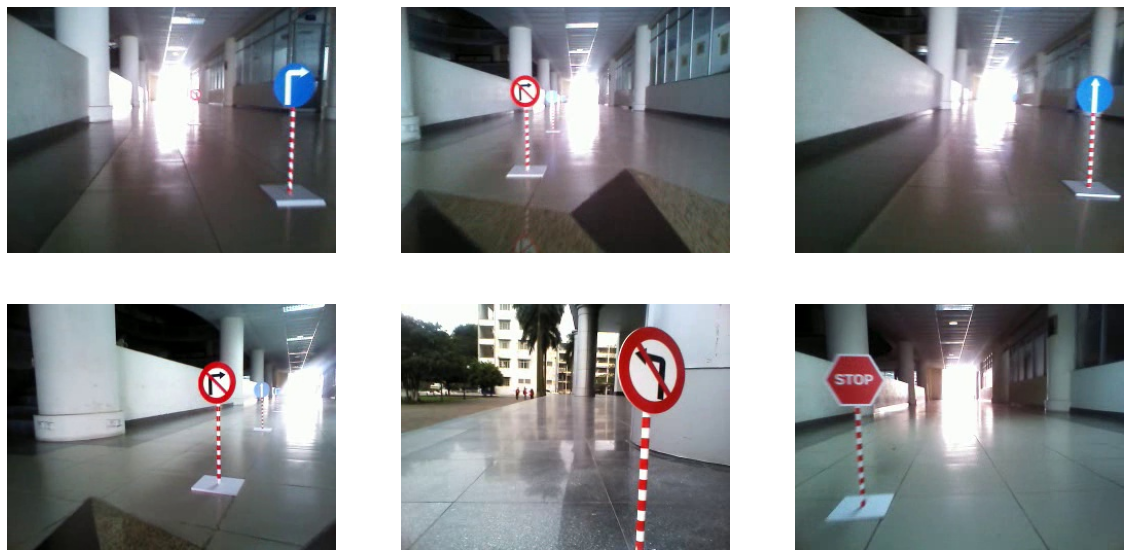

In [4]:
# Read and show example images
image_names = range(1,7)
print(image_names)
bgr_images = [cv2.imread(str(name) + ".jpg") for name in image_names]
show_images(bgr_images)

As in the lane line detection section, we use `cv2.cvtColor()` for color conversion.

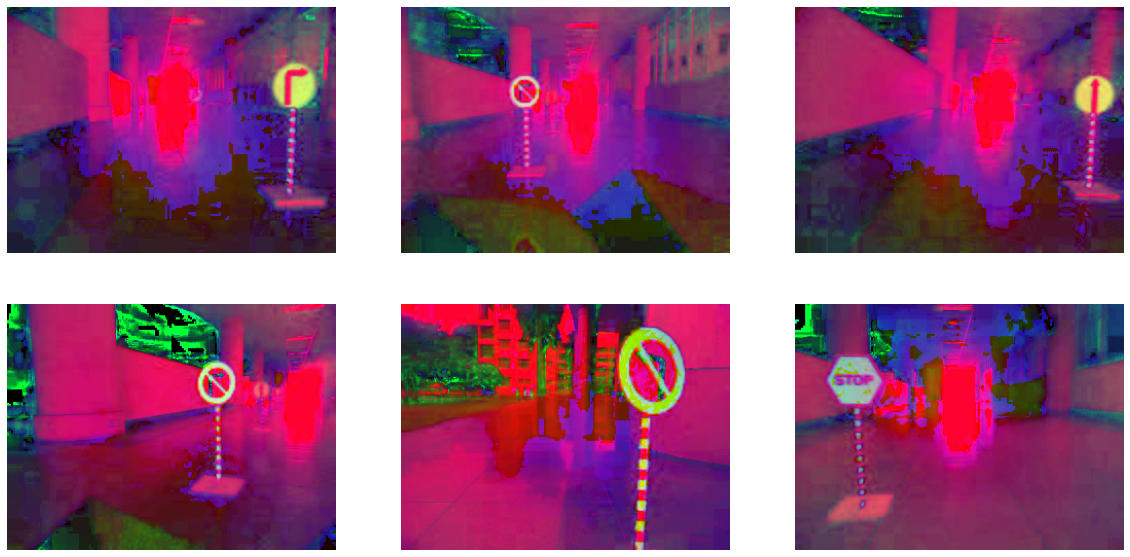

In [5]:
hsvs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in bgr_images]
show_images(hsvs)

Here `cv2.inRange()` is used for filter interested colors. All color filtering steps are combined into `filter_signs_by_color()` function.

In [6]:
def filter_signs_by_color(image):
    """Filter all objects with red or blue color - traffic sign candidate
    """

    # Convert image to HSV color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Filter red. There are two range of red color
    lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask_1 = cv2.inRange(image, lower1, upper1)
    mask_2 = cv2.inRange(image, lower2, upper2)
    mask_r = cv2.bitwise_or(mask_1, mask_2)

    # Filter blue color
    lower3, upper3 = np.array([100, 150, 0]), np.array([140, 255, 255])
    mask_b = cv2.inRange(image, lower3, upper3)

    # Combine the result
    mask_final = cv2.bitwise_or(mask_r, mask_b)
    return mask_final

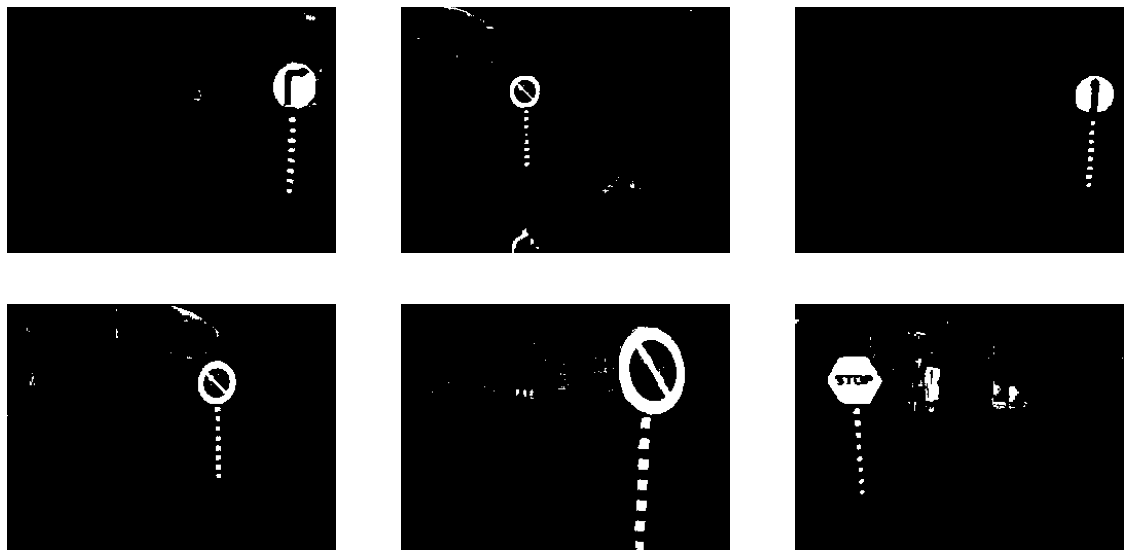

In [7]:
masks = [filter_signs_by_color(img) for img in bgr_images]
show_images(masks)

After filtering the sign candidates by their color, the result contains all the objects in red or blue, such as the signs, poles, or background areas. In the next step, we need to filter the noise objects and find traffic sign bounding boxes. We also apply post-processing to filter too small, too large objects or objects with too different width/height ratios compared to traffic signs.

In [8]:
def get_boxes_from_mask(mask):
    """Find bounding boxes from color
    """
    bboxes = []

    nccomps = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = nccomps
    im_height, im_width = mask.shape[:2]
    for i in range(numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        # Filter small objects
        # (width < 20 or height < 20)
        if w < 20 or h < 20:
            continue
        # Filter too large objects
        if w > 0.8 * im_width or h > 0.8 * im_height:
            continue
        # Remove objects with too different width/height ratio
        if w / h > 2.0 or h / w > 2.0:
            continue
        bboxes.append([x, y, w, h])
    return bboxes

Draw the results

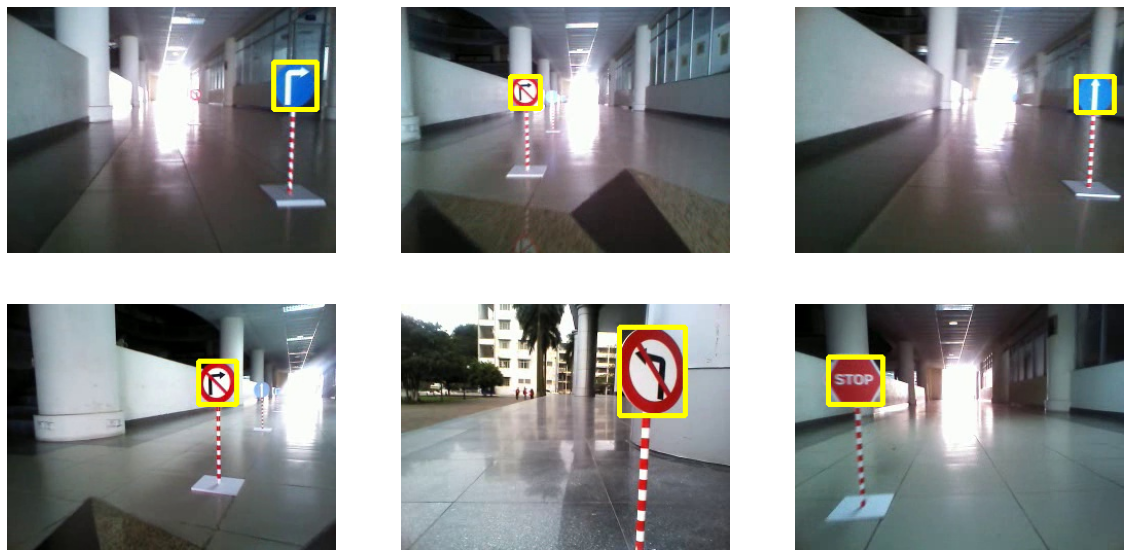

In [9]:
results = []
for i, img in enumerate(bgr_images):
    mask = filter_signs_by_color(img) # Filter by color
    bboxes = get_boxes_from_mask(mask) # Finding bounding boxes
    draw = img.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        # Draw bounding box
        cv2.rectangle(draw, (x,y), (x+w,y+h), (0,255,255), 4)
    results.append(draw)
show_images(results)

## 2. Classify traffic signs with convolutional neural network

After filtering the signs by color, the next thing we need to do is to classify them into different signs (stop, turn left, turn right, prohibit left turn, prohibited turn right, go straight). Objects other than signs are also recognized and classified as unknown.

We will use convolutional neural network architecture (CNN) for classification. CNN is one of the advanced machine learning models. It helps us build intelligent systems for recognition with high accuracy. You can imagine each convolutional layer in CNN is just like a set of filters we used before such as mean, gaussian or Sobel filters. However, the kernel parameters of CNN layers are learned from the data to extract useful features for image recognition tasks. You can learn more about CNN from [this blog post](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939).

The input of the classification network is an image, which goes through some convolutional layers to extract features for classification. After that, we add some fully connected layers to get the prediction result. The final result answers the question: **what type of sign does the object belong to?**

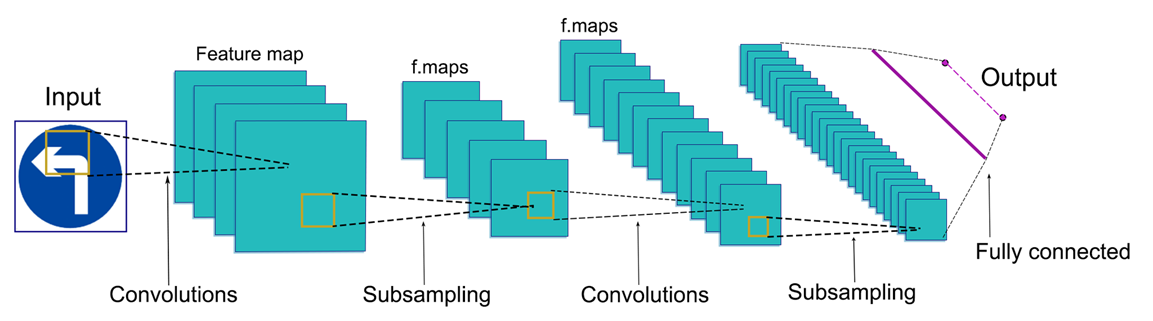


### Experiment with pretrained model based on LeNet

Designing and training neural networks takes time. In order to give you a quick result, we have a pretrained traffic sign classifier based on [LeNet](https://en.wikipedia.org/wiki/LeNet). This classification model can be loaded in OpenCV with `cv2.dnn.readNetFromONNX()`. We provide the function `detect_traffic_signs()` to inference and get the classification result.

In [10]:
# Download our pretained model
!wget https://github.com/vietanhdev/sdc-tutorial/raw/master/p2_traffic_sign_detection/traffic_sign_classifier_lenet_v3.onnx

--2021-12-04 11:04:59--  https://github.com/vietanhdev/sdc-tutorial/raw/master/p2_traffic_sign_detection/traffic_sign_classifier_lenet_v3.onnx
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vietanhdev/sdc-tutorial/master/p2_traffic_sign_detection/traffic_sign_classifier_lenet_v3.onnx [following]
--2021-12-04 11:04:59--  https://raw.githubusercontent.com/vietanhdev/sdc-tutorial/master/p2_traffic_sign_detection/traffic_sign_classifier_lenet_v3.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457797 (447K) [application/octet-stream]
Saving to: ‘traffic_sign_classifier_lenet_v3.onnx’

traffic_s

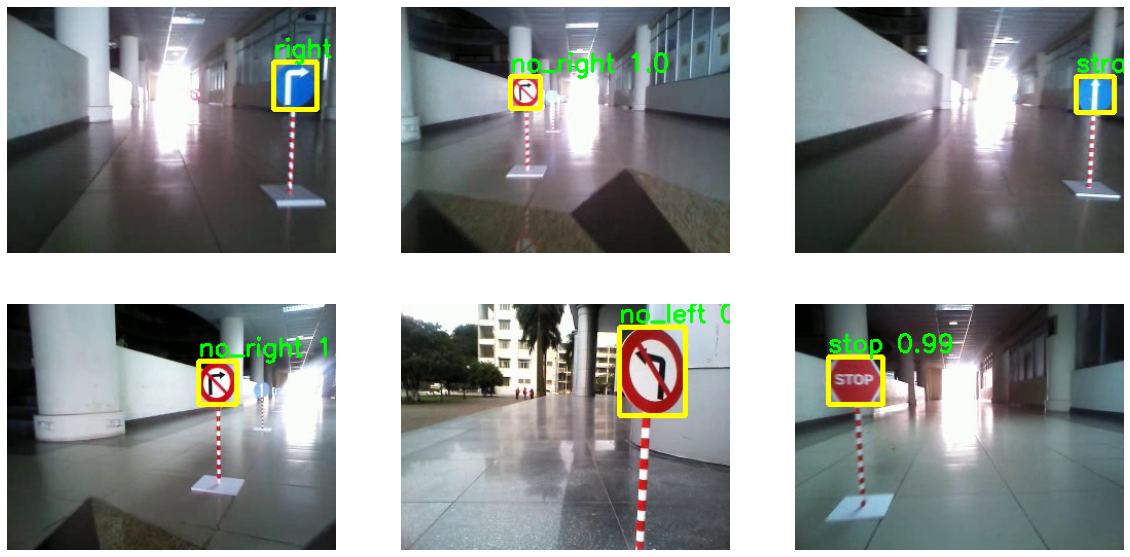

In [11]:
def detect_traffic_signs(img, model, draw=None):
    """Detect traffic signs on and image
    """

    # Traffic sign classes. unknown means "not a traffic sign"
    classes = ['unknown', 'left', 'no_left', 'right',
               'no_right', 'straight', 'stop']

    # Detect traffic signs by color
    mask = filter_signs_by_color(img)
    bboxes = get_boxes_from_mask(mask)

    # Preprocess
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 255.0

    # Classify signs using CNN
    signs = []
    for bbox in bboxes:
        # Crop sign area
        x, y, w, h = bbox
        sub_image = img[y:y+h, x:x+w]

        if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
            continue

        # Preprocess
        sub_image = cv2.resize(sub_image, (32, 32))
        sub_image = np.expand_dims(sub_image, axis=0)

        # Use CNN to get prediction
        model.setInput(sub_image)
        preds = model.forward()
        preds = preds[0]
        cls = preds.argmax()
        score = preds[cls]

        # Remove unknown objects
        if cls == 0:
            continue

        # Remove low confidence objects
        if score < 0.5:
            continue

        signs.append([classes[cls], x, y, w, h])

        # Draw prediction result
        if draw is not None:
            text = classes[cls] + ' ' + str(round(score, 2))
            cv2.rectangle(draw, (x, y), (x+w, y+h), (0, 255, 255), 4)
            cv2.putText(draw, text, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return signs
        

# Initialize model using OpenCV
model = cv2.dnn.readNetFromONNX("traffic_sign_classifier_lenet_v3.onnx")

draws = []
for i, img in enumerate(bgr_images):
    draw = img.copy()
    # Detect traffic sign and draw the result to "draw"
    signs = detect_traffic_signs(img, model, draw=draw)
    draws.append(draw)
show_images(draws)


### Train your own classifier

If you want to modify the traffic sign classifier or train it with your own data, visit our notebook below.

https://colab.research.google.com/drive/1GWnxRnSLR_NEocuvLvKjm4UpS6Nhz1WL#scrollTo=mYOr9xyiVHe-